In [68]:
import pandas as pd
import json, re, nltk, string
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
with open('data/tweets/final_data.json', 'r') as f:
    data = json.load(f)

In [3]:
for user in data['selected_users_tweets'].keys():
    tweets = data['selected_users_tweets'][user]
    _tweets = list()
    for tt in tweets:
        if tt not in _tweets:
            _tweets.append(tt)
    data['selected_users_tweets'][user] = ' '.join(_tweets)

In [4]:
users_tweets = list()

for user in data['selected_users_tweets'].keys():
    users_tweets.append((user, data['selected_users_tweets'][user]))

user_tweets_df = pd.DataFrame(columns=['user', 'tweets_tweet'], data=users_tweets)
user_tweets_df.sample(5)

,user,tweets_txt
635,VarisonAndressa,Bolsonaro GANHOU. Qual a novidade? \n\nO que o...
774,dornele6,BEBENDO ESSA EM HOMENAGEM AOS 51% DO MITO \n#B...
805,AndrezaMarks,"#BolsonaroReeleito\n“Não parar, não precipitar..."
60,M_Cristian18,"Patriota, você pode saudar pneu, criar teoria ..."
48,CrisSilvaSJC,O nível da equipe de filmagem kkkk\nvai ter su...


In [5]:
users_comm = list()

for user in data['user_comm_mapping'].keys():
    users_comm.append((user, data['user_comm_mapping'][user]))

user_comm_df = pd.DataFrame(columns=['user', 'comm_label'], data=users_comm)
user_comm_df.sample(5)

,user,comm_label
13,queenvermelha13,0
87,CeticoLover,0
153,Fabiana29202402,0
1532,livialternativa,0
656,argentina_info2,1


In [61]:
user_comm_df['comm_label'].value_counts()

1    1109
0     439
Name: comm_label, dtype: int64

#### Text Preprocessing

In [14]:
stop_words = nltk.corpus.stopwords.words('portuguese')

In [38]:
def remove_emoji(tweet: str):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return emoji_pattern.sub(r'', tweet)


def remove_link(tweet: str):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'bit.ly/\S+', '', tweet)
    tweet = tweet.strip('[link]')
    tweet = re.sub(r'pic.twitter\S+', '', tweet)
    return tweet


def remove_mentions(tweet: str):
    return re.sub(r'@[A-Za-z0-9_]+', ' ', tweet)



def remove_hashtag(tweet: str):
    return re.sub(r'#[A-Za-z0-9_]+', ' ', tweet)


def remove_av(tweet: str):
    tweet = re.sub(r'video:', '', tweet)
    tweet = re.sub(r'audio:', '', tweet)
    return tweet


def remove_punctuation(tweet: str):
    tweet = tweet
    for char in tweet:
        if char in string.punctuation:
            tweet = tweet.replace(char, ' ')
    return tweet


def prep_tweet(tweet: str):
    tweet = tweet.lower()
    tweet = remove_emoji(tweet)
    tweet = remove_link(tweet)
    tweet = remove_mentions(tweet)
    tweet = remove_hashtag(tweet)
    tweet = remove_av(tweet)
    tweet = remove_punctuation(tweet)
    tweet = ' '.join([w for w in word_tokenize(tweet) if len(w)>1])
    return unidecode(tweet)

In [43]:
user_tweets_df['tweets_preproc'] = user_tweets_df['tweets_txt'].map(lambda x: prep_tweet(x))

In [46]:
user_tweets_df.sample(5)

,user,tweets_txt,tweets_preproc
973,ApenasTruthNews,"Bolsonaro foi reeleito, as eleições foram muit...",bolsonaro foi reeleito as eleicoes foram muito...
412,FranLSNeto,Acho que ficou com medo de ser “ovacionado” na...,acho que ficou com medo de ser ovacionado nas ...
761,vnia_wenzel1,"Querem impor Lule no tapetão! Urnas suspeitas,...",querem impor lule no tapetao urnas suspeitas e...
561,Ecletica1,#BolsonaroReeleito\nQual a similaridade entre ...,qual similaridade entre uma imagem outra tse v...
628,alinepsn_,SOBRE O RELATÓRIO DO P.L.: VAMOS AGUARDAR A AN...,sobre relatorio do vamos aguardar analise do c...


#### Clustering

In [52]:
vec = TfidfVectorizer()
features = vec.fit_transform(user_tweets_df['tweets_preproc'])

In [58]:
km = KMeans(n_clusters=2, algorithm='lloyd')
km.fit(features)

KMeans(n_clusters=2)

In [60]:
labels = km.labels_

s_counts = pd.Series(labels).value_counts()
s_perc = pd.Series(labels).value_counts(normalize=True).values
for idx, val, perc in zip(s_counts.index, s_counts.values, s_perc):
    print(f'Cluster {idx}: {val} ({perc*100:.2f}%)')


Cluster 1: 1130 (73.00%)
Cluster 0: 418 (27.00%)


In [65]:
result = pd.DataFrame({'user': user_tweets_df['user'], 'tweets': user_tweets_df['tweets_preproc'], 'cluster':labels})
result.head()

,user,tweets,cluster
0,VidorLu,lula ta eleito lula ta eleito lula ta eleito l...,0
1,fonncllau10,desiste bozo...o lula ta eleito,0
2,giordano_girl,lula ta eleito acabou porra pra que jair quer ...,0
3,gonagipe,precisa especificar qual cargo afinal esse va ...,1
4,jamlima77,lula ta eleito,0


In [63]:
user_comm_df.head()

,user,comm_label
0,VidorLu,0
1,fonncllau10,0
2,giordano_girl,0
3,gonagipe,0
4,jamlima77,0


Cluster :  0


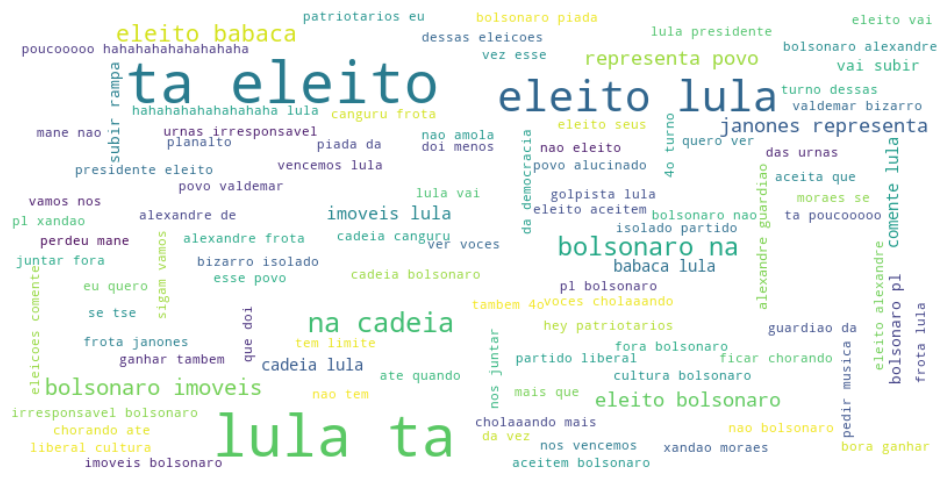

Cluster :  1


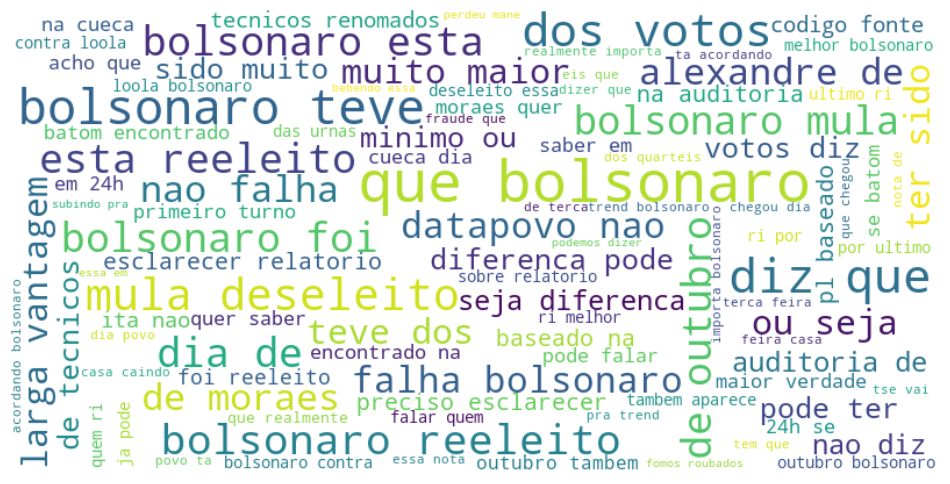

In [70]:


for k in range(0, 2):
    s = result[result['cluster']==k]
    text = s['tweets'].str.cat(sep=' ')
    text = text.lower()
    text = ' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white', width=800, height=400).generate(text)
    print('Cluster : ', k)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

#### Results

In [73]:
result_df = result
result_df['community_label'] = user_comm_df['comm_label']

In [74]:
result_df.sample(10)

,user,tweets,cluster,community_label
168,AstralSandro,me sigam vamos nos juntar fora bolsonaro alexa...,0,0
225,sahesilva19,lula ta eleito lulinha lula ta eleito desiste ...,0,0
17,zurenemanique,nos vencemos lula ta eleito lula ta eleito per...,0,0
128,danilohugou,gol do camisa 13 pra lembrar todos de que lula...,0,0
1160,victorbuchmann_,lula ta eleito respeita meu voto resultado das...,0,0
425,joaovoltou,xandao esta desesperado pois sabe que pode ser...,1,1
472,LauraApGC1,querem impor lule no tapetao urnas suspeitas e...,1,1
1388,MarcosBFabro,bolsonaro 51 meus amigos de uma coisa eu sei n...,1,1
1076,Douglas70211690,de acordo com relatorio das urnas teriamos 51 ...,1,1
887,celestinoAB,preciso esclarecer relatorio do pl baseado na ...,1,1


In [76]:
acc = (result_df['cluster']==result_df['community_label']).mean()
print("%.2f%%"%(acc*100))

98.64%


In [78]:
result_df[result_df['cluster']!=result_df['community_label']]

,user,tweets,cluster,community_label
3,gonagipe,precisa especificar qual cargo afinal esse va ...,1,0
6,kelvin_a10,alexandre de morais joga um balde de agua fria...,1,0
10,netto41,os malucos ainda tao insistindo nessa historia...,1,0
11,oicram2016,lula ta eleito ja fazendo papel de presidente ...,1,0
32,ZellFlorizel,lula ta eleito bolsonaro 51 imoveis sentiram l...,1,0
34,Rosaniba,lula ta eleito babaca ve se se manca para de e...,1,0
42,daniduncan,,1,0
47,CarlucciMurilo,lula ta eleito se as provas que pl mostrou se ...,1,0
52,DielNascimento4,lula ta eleito babacas pl bolsonaro venceu seg...,1,0
60,M_Cristian18,patriota voce pode saudar pneu criar teoria da...,1,0
